In [6]:
#basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
sns.set()
import os
import sys
import tomotopy as tp
import os
import re
import pyLDAvis 
import seaborn as sns
import urllib
from urllib.request import urlretrieve
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import pickle

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))
#print(os.walk('/kaggle/input'))

In [2]:
def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

def calculate_relevance(topic_term_dists, term_freqs, lambda_param=0.6):
    """Calculate relevance for each term in each topic."""
    topic_term_dists = np.array(topic_term_dists)
    term_freqs = np.array(term_freqs)
    term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies
    relevance = lambda_param * np.log(topic_term_dists) + (1 - lambda_param) * np.log(topic_term_dists / term_freqs)
    normalized_relevance = normalize_scores(relevance)
    return normalized_relevance

'''def calculate_saliency(topic_term_dists, term_freqs):
    """Calculate saliency for each term."""
    p_w = term_freqs / term_freqs.sum()
    saliency = (topic_term_dists * np.log(topic_term_dists / p_w)).sum(axis=0)
    return saliency'''
def calculate_saliency(topic_term_dists, term_freqs):
    term_freqs = np.array(term_freqs)
    term_freqs = term_freqs / term_freqs.sum()  # Normalize term frequencies

    num_topics, num_terms = topic_term_dists.shape
    saliency = np.zeros_like(topic_term_dists)
    for k in range(num_topics):  # For each topic
        for w in range(num_terms):  # For each word in the vocabulary
            p_word_given_topic = topic_term_dists[k, w]
            p_word_in_corpus = term_freqs[w]
            saliency[k, w] += p_word_given_topic * np.log(p_word_given_topic / p_word_in_corpus)
    
    # for term_idx in range(num_terms):
    #     # p(t | w) is topic_term_dists[:, term_idx]
    #     p_t_given_w = topic_term_dists[:, term_idx]
        
    #     # p(t) is the overall topic distribution
    #     p_t = np.mean(topic_term_dists, axis=1)
        
    #     # Calculate saliency for the term
    #     saliency_term = np.sum(p_t_given_w * np.log(p_t_given_w / p_t)) * term_freqs[term_idx]
    #     saliency[term_idx] = saliency_term
    normalized_saliency = normalize_scores(saliency)
    return normalized_saliency


In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    stop_words = set(["a", "an", "the", "and", "or", "but", "if", "on", "in", "to", "is", "of", "for", 'you', 'that', 'are', 'with'])
    words = [word for word in text.split() if len(word) > 2 and word not in stop_words]
    return words

In [4]:

def lda_example(file_paths, timestamps):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=13   )#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    mdl.add_doc(words)
                    doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    mdl.summary()

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    
    d = {'pdf':[],'authors': [], 'titles': [], 'number': [], 'available':[]}
    LDA_all = pd.DataFrame({
            'Probability Words': [],
            'Relevance Words': [],
            'Saliency Words': [],
            'Probability Scores': [],
            'Relevance Scores': [],
            'Saliency Scores': []
        })
    
    topics=[]
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:3]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:3]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:3]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [score for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [score for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [score for _, score in top_saliency_words]
        
        
        

        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })
        LDA_all = pd.concat([LDA_all, combined_df], ignore_index=True)
        combined_df.to_csv(f'results{k}.csv')
        print(combined_df.to_string(index=False))
    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )
    pyLDAvis.save_html(prepared_data, 'ldavis.html')
    # Aggregate topic distributions by time periods
    df = pd.DataFrame(doc_topic_dists, columns=[f'Topic_{i}' for i in range(mdl.k)])
    df['Timestamp'] = doc_timestamps
    
    # Calculate the average topic distribution for each time period
    topic_over_time = df.groupby('Timestamp').mean().reset_index()
    
    # Smooth out the frequency lines using a rolling average
    topic_over_time_smooth = topic_over_time.set_index('Timestamp').rolling(window=6, min_periods=1).mean().reset_index()
    
    # Plot the topic frequencies over time
    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns[1:]:
        plt.plot(topic_over_time_smooth['Timestamp'], topic_over_time_smooth[topic], label=topic)
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
    df_melted = topic_over_time_smooth.melt(id_vars='Timestamp', var_name='Topic', value_name='Proportion')
    g = sns.FacetGrid(df_melted, col='Topic', col_wrap=4, sharey=False, height=3)
    g.map(sns.lineplot, 'Timestamp', 'Proportion')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels('Time Period', 'Average Topic Proportion')
    g.fig.suptitle('Topic Frequencies Over Time (Smoothed)', y=1.02)  # Title with better positioning
    g.add_legend()
    plt.tight_layout()
    plt.show()

In [15]:

def lda_quick(file_paths, timestamps, num):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=num)#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    mdl.add_doc(words)
                    doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    #print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    mdl.removed_top_words
    #print('Removed top words:', mdl.removed_top_words)
    #print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    #mdl.summary()
    
    topics=[]
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        
    return topics, texts, dictionary 

In [10]:

def get_all_files_in_directory(directory):
    file_paths = []
    timestamps = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_paths.append(os.path.join(root, file))
                timestamp = os.path.basename(root)
                timestamps.append(timestamp)
    return file_paths, timestamps



In [11]:
# Path to the main directory containing subdirectories with text files
main_directory_path = './PSB_Papers/main_body'

print('Running LDA')

# Get all file paths in the main directory and its subdirectories
file_paths, timestamps = get_all_files_in_directory(main_directory_path)

Running LDA


In [16]:
scores = []
for i in range(3, 20):
    topics, texts, dictionary  = lda_quick(file_paths, timestamps, i)
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f'Coherence Score: {coherence_score}')
    scores.append(coherence_score)

Iteration: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s, LLPW: -8.620799]


Coherence Score: 0.34807462687055235


Iteration: 100%|██████████| 100/100 [00:38<00:00,  2.56it/s, LLPW: -8.651857]


Coherence Score: 0.42968833381971305


Iteration: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s, LLPW: -8.690719]


Coherence Score: 0.43568686318846356


Iteration: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s, LLPW: -8.737475]


Coherence Score: 0.43497792005026176


Iteration: 100%|██████████| 100/100 [00:34<00:00,  2.86it/s, LLPW: -8.757345]


Coherence Score: 0.4921824148847443


Iteration: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, LLPW: -8.755949]


Coherence Score: 0.4554099009874528


Iteration: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s, LLPW: -8.759013]


Coherence Score: 0.45161901131251014


Iteration: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s, LLPW: -8.769358]


Coherence Score: 0.4915630939058886


Iteration: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s, LLPW: -8.814424]


Coherence Score: 0.4764019301515059


Iteration: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s, LLPW: -8.812862]


Coherence Score: 0.5002314882273095


Iteration: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s, LLPW: -8.853741]


Coherence Score: 0.5236791334863978


Iteration: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s, LLPW: -8.837851]


Coherence Score: 0.46465082546884506


Iteration: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s, LLPW: -8.866104]


Coherence Score: 0.5215174178898275


Iteration: 100%|██████████| 100/100 [00:13<00:00,  7.54it/s, LLPW: -8.874091]


Coherence Score: 0.511082184675808


Iteration: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s, LLPW: -8.891211]


Coherence Score: 0.5005656327168648


Iteration: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, LLPW: -8.907165]


Coherence Score: 0.5139622056064032


Iteration: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s, LLPW: -8.876298]


Coherence Score: 0.49584206060640956


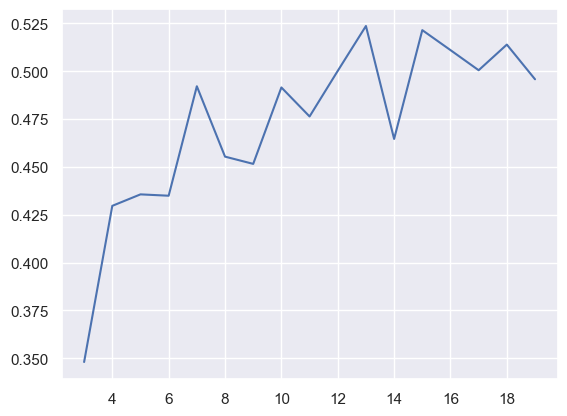

In [17]:
plt.plot(range(3,20), scores)

Training...


Num docs: 349035 , Vocab size: 20287 , Num words: 2151360
Removed top words: ['gene', 'set', 'using', 'genes', 'number', 'used', 'two', 'one', 'protein', 'based', 'also', 'methods', 'sequence', 'network', 'expression']


Iteration: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s, LLPW: -8.841586]


<Basic Info>
| LDAModel (current version: 0.12.7)
| 349035 docs, 2151360 words
| Total Vocabs: 30729, Used Vocabs: 20287
| Entropy of words: 8.35542
| Entropy of term-weighted words: 8.35542
| Removed Vocabs: gene set using genes number used two one protein based also methods sequence network expression
|
<Training Info>
| Iterations: 100, Burn-in steps: 500
| Optimization Interval: 10
| Log-likelihood per word: -8.82890
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 14 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 706886344 (random seed)
| trained in version 0.1

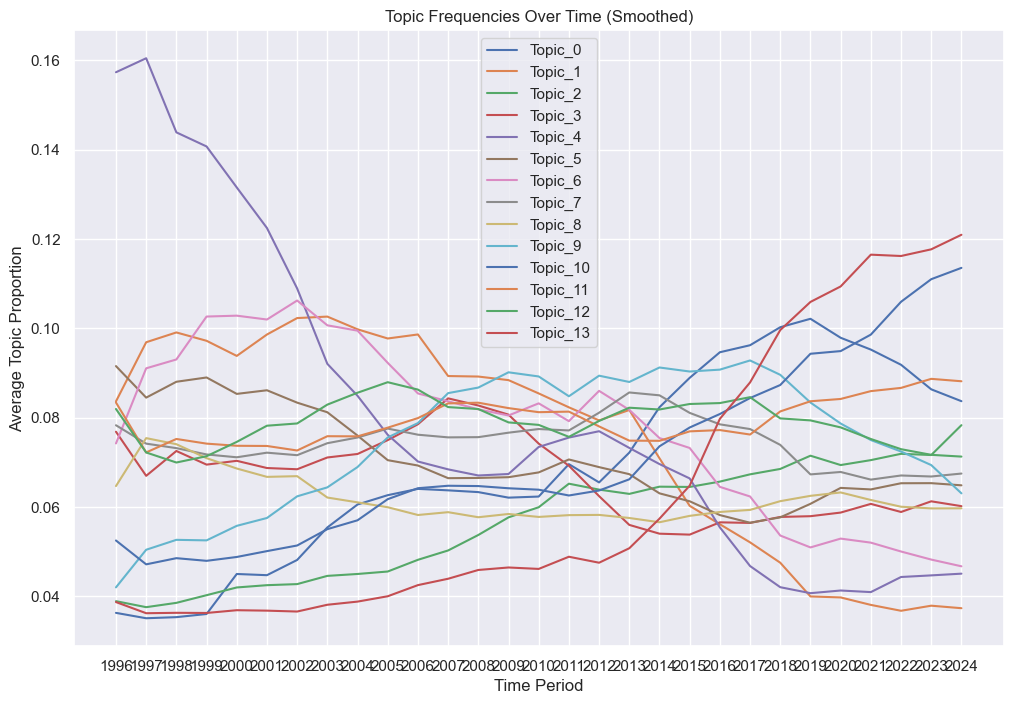

<Figure size 1400x1000 with 0 Axes>

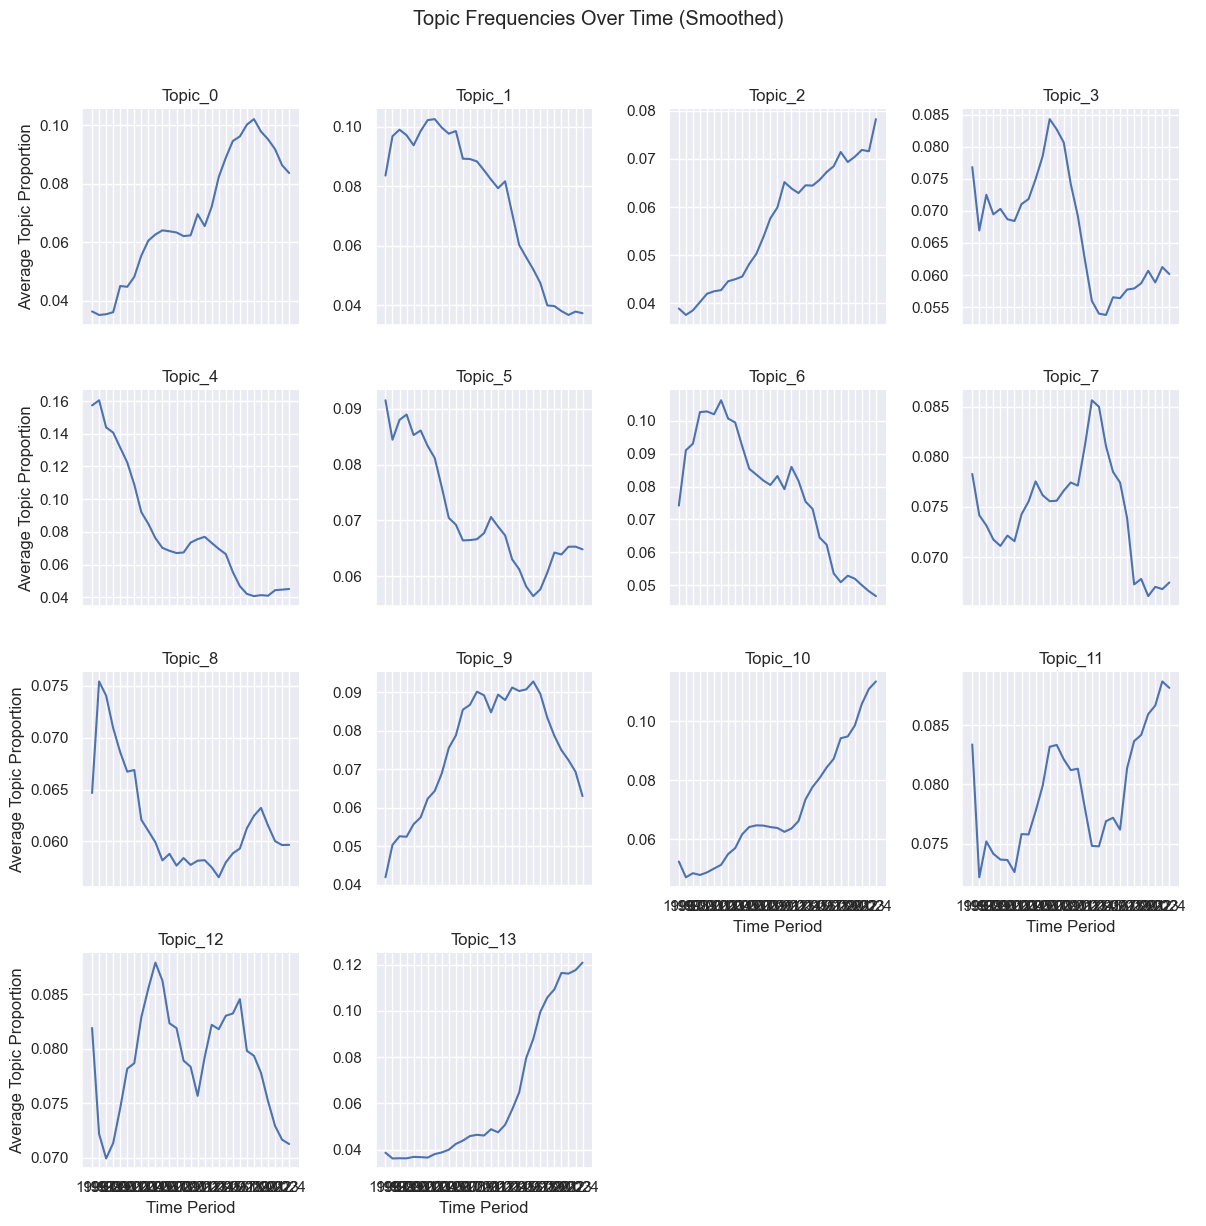

In [19]:
# Run the LDA model on all files
lda_example(file_paths, timestamps)

In [25]:
def lda_find_favorite(file_paths, timestamps, word_num=5):
    mdl = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=3, rm_top=15, k=14   )#,#tw=tp.TermWeight.IDF)#alpha=0.1, eta=0.01)
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    mdl.add_doc(words)
                    doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    mdl.burn_in = 500
    mdl.train(0)
    print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
    print('Removed top words:', mdl.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    mdl.train(100, show_progress=True)
    mdl.summary()

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    
    d = {'pdf':[],'authors': [], 'titles': [], 'number': [], 'available':[]}
    LDA_all = pd.DataFrame({
            'Probability Words': [],
            'Relevance Words': [],
            'Saliency Words': [],
            'Probability Scores': [],
            'Relevance Scores': [],
            'Saliency Scores': []
        })
    
    topics=[]
    fin_df = {'Topic':[], 'Type':[], 'Words':[], 'Scores':[]}
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:word_num]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:word_num]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:word_num]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [str(score)[:4] for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [str(score)[:4] for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [str(score)[:4] for _, score in top_saliency_words]
        
        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })

        Topics = [f'Topic {k}' for i in range(3)]
        fin_df['Topic'] += Topics
        Type = ['Probability', 'Relevance', 'Saliency']
        fin_df['Type'] += Type
        Words = [" ".join(prob_words), " ".join(relevance_words), " ".join(saliency_words)]
        fin_df['Words'] += Words
        Scores = [" ".join(prob_values), " ".join(relevance_values),  " ".join(saliency_values)]
        fin_df['Scores'] += Scores
        LDA_all = pd.concat([LDA_all, combined_df], ignore_index=True)
        combined_df.to_csv(f'results{k}.csv')
        print(combined_df.to_string(index=False))
    fin_df = pd.DataFrame(data=fin_df)
    fin_df.to_csv('results.csv')    
    return mdl

In [5]:
models = []

In [26]:
model = lda_find_favorite(file_paths, timestamps)
i=0
models.append(model)
model.save(f"lda_model{i}.bin")

Training...


Num docs: 348833 , Vocab size: 20283 , Num words: 2139281
Removed top words: ['gene', 'set', 'using', 'genes', 'number', 'used', 'two', 'one', 'protein', 'based', 'also', 'methods', 'sequence', 'network', 'expression']


Iteration: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, LLPW: -8.875752]


<Basic Info>
| LDAModel (current version: 0.12.7)
| 348833 docs, 2139281 words
| Total Vocabs: 30725, Used Vocabs: 20283
| Entropy of words: 8.36029
| Entropy of term-weighted words: 8.36029
| Removed Vocabs: gene set using genes number used two one protein based also methods sequence network expression
|
<Training Info>
| Iterations: 100, Burn-in steps: 500
| Optimization Interval: 10
| Log-likelihood per word: -8.86127
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 14 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3444455847 (random seed)
| trained in version 0.

In [33]:
def Graph_From_Model( file_paths, timestamps, mdl):
    doc_timestamps = []
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    # mdl.add_doc(words)
                    doc_timestamps.append(timestamp)
    dictionary = corpora.Dictionary(texts)


    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)

    prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )
    pyLDAvis.save_html(prepared_data, 'ldavis.html')
    # Aggregate topic distributions by time periods
    df = pd.DataFrame(doc_topic_dists, columns=[f'Topic_{i}' for i in range(mdl.k)])
    df['Timestamp'] = doc_timestamps
    
    # Calculate the average topic distribution for each time period
    topic_over_time = df.groupby('Timestamp').mean().reset_index()
    
    # Smooth out the frequency lines using a rolling average
    topic_over_time_smooth = topic_over_time.set_index('Timestamp').rolling(window=6, min_periods=1).mean().reset_index()
    
    # Plot the topic frequencies over time
    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns[1:]:
        plt.plot(topic_over_time_smooth['Timestamp'], topic_over_time_smooth[topic], label=topic)
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility
    df_melted = topic_over_time_smooth.melt(id_vars='Timestamp', var_name='Topic', value_name='Proportion')
    g = sns.FacetGrid(df_melted, col='Topic', col_wrap=4, sharey=False, height=3)
    g.map(sns.lineplot, 'Timestamp', 'Proportion')
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels('Time Period', 'Average Topic Proportion')
    g.fig.suptitle('Topic Frequencies Over Time (Smoothed)', y=1.02)  # Title with better positioning
    g.add_legend()
    plt.tight_layout()
    plt.show()

[[0.01676319 0.77413351 0.8017409  ... 0.24977183 0.24977183 0.24977183]
 [0.92328203 0.00241852 0.6805462  ... 0.23380716 0.23380716 0.23380716]
 [0.7484294  0.0026864  0.83169979 ... 0.23407505 0.23407505 0.23407505]
 ...
 [0.79598641 0.87668708 0.84225754 ... 0.24038691 0.24038691 0.24038691]
 [0.76450059 0.00318786 0.83300547 ... 0.2345765  0.2345765  0.2345765 ]
 [0.92261649 0.         0.8465731  ... 0.23138864 0.23138864 0.23138864]] [[0.01709119 0.00215781 0.00765803 ... 0.01710069 0.01710069 0.01710069]
 [0.22337893 0.0170935  0.00438526 ... 0.01710117 0.01710117 0.01710117]
 [0.         0.01709347 0.02212822 ... 0.01710116 0.01710116 0.01710116]
 ...
 [0.00473472 0.07710832 0.03053349 ... 0.01710098 0.01710098 0.01710098]
 [0.00037374 0.01709341 0.02305491 ... 0.01710115 0.01710115 0.01710115]
 [0.2201984  0.01709381 0.03462255 ... 0.01710124 0.01710124 0.01710124]]


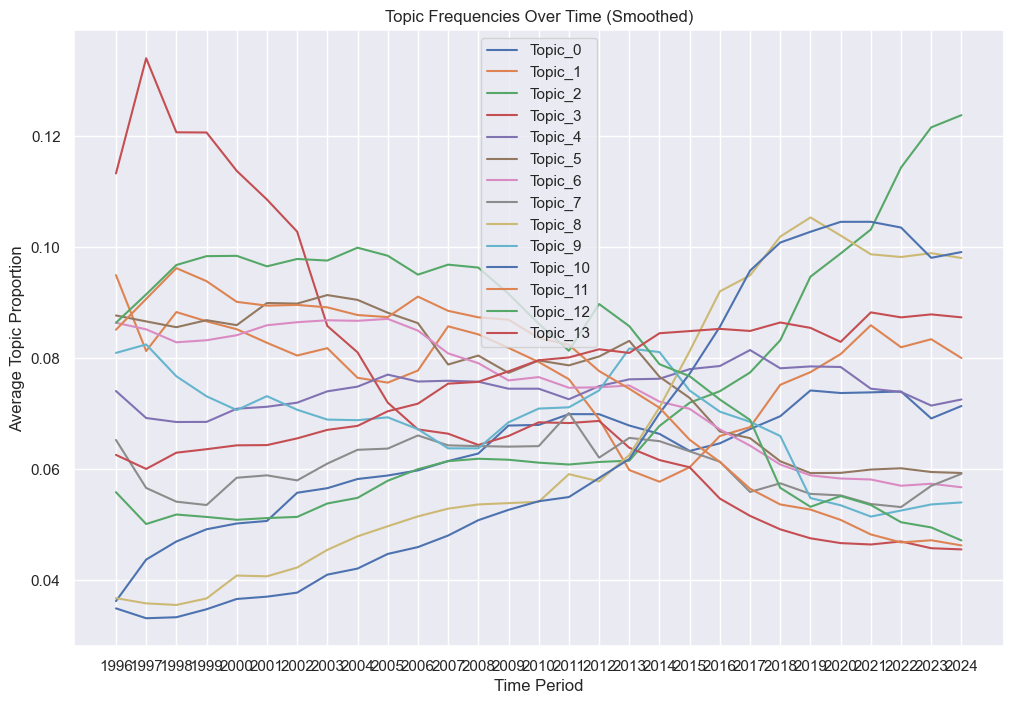

<Figure size 1400x1000 with 0 Axes>

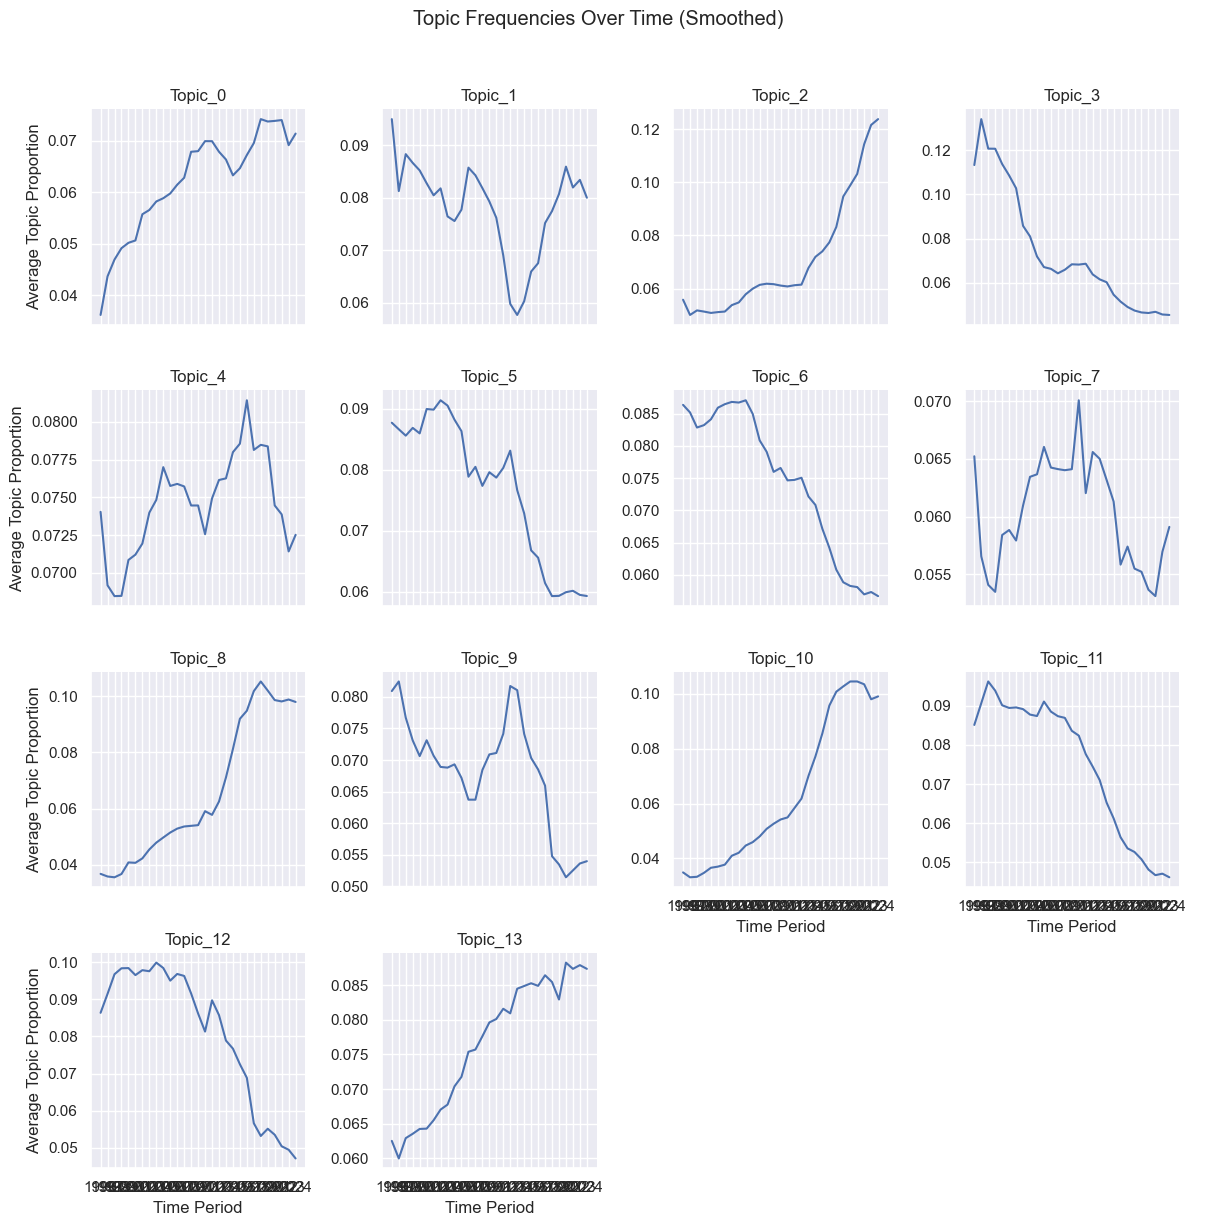

In [34]:
Graph_From_Model(file_paths, timestamps,  tp.LDAModel.load("lda_model0.bin"))

In [ ]:
def lda_find_favorite(file_paths, timestamps, mdl, word_num=5):
    texts = []
    for file_path, timestamp in zip(file_paths, timestamps):
        with open(file_path, encoding='utf-8') as f:
            for line in f:
                words = preprocess_text(line.strip())
                if words:
                    texts.append(words)
                    mdl.add_doc(words)
                    doc_timestamps.append(timestamp)

    topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    vocab = list(mdl.used_vocabs)
    term_frequency = mdl.used_vocab_freq

    
    relevance = calculate_relevance(topic_term_dists, term_frequency)
    saliency = calculate_saliency(topic_term_dists, term_frequency)
    
    print(relevance, saliency)
    
    d = {'pdf':[],'authors': [], 'titles': [], 'number': [], 'available':[]}
    LDA_all = pd.DataFrame({
            'Probability Words': [],
            'Relevance Words': [],
            'Saliency Words': [],
            'Probability Scores': [],
            'Relevance Scores': [],
            'Saliency Scores': []
        })
    
    topics=[]
    fin_df = {'Topic':[], 'Type':[], 'Words':[], 'Scores':[]}
    for k in range(mdl.k):
        topic = [word for word, _ in mdl.get_topic_words(k)]
        topics.append(topic)
        print(f'Topic #{k}')
        words_probs = mdl.get_topic_words(k)
        top_prob_words = [(word, prob) for word, prob in words_probs[:word_num]]

        relevance_scores = relevance[k]
        relevance_indices = np.argsort(relevance_scores)[::-1]
        saliency_scores = saliency[k]
        saliency_indices = np.argsort(saliency_scores)[::-1]

        top_relevance_words = [(vocab[idx], relevance_scores[idx]) for idx in relevance_indices[:word_num]]
        top_saliency_words = [(vocab[idx], saliency_scores[idx]) for idx in saliency_indices[:word_num]]

        prob_words = [word for word, _ in top_prob_words]
        prob_values = [str(score)[:4] for _, score in top_prob_words]
        relevance_words = [word for word, _ in top_relevance_words]
        relevance_values = [str(score)[:4] for _, score in top_relevance_words]
        saliency_words = [word for word, _ in top_saliency_words]
        saliency_values = [str(score)[:4] for _, score in top_saliency_words]
        
        # Create DataFrame with words and scores for all three metrics
        combined_df = pd.DataFrame({
            'Probability Words': prob_words,
            'Relevance Words': relevance_words,
            'Saliency Words': saliency_words,
            'Probability Scores': prob_values,
            'Relevance Scores': relevance_values,
            'Saliency Scores': saliency_values
        })

        Topics = [f'Topic {k}' for i in range(3)]
        fin_df['Topic'] += Topics
        Type = ['Probability', 'Relevance', 'Saliency']
        fin_df['Type'] += Type
        Words = [" ".join(prob_words), " ".join(relevance_words), " ".join(saliency_words)]
        fin_df['Words'] += Words
        Scores = [" ".join(prob_values), " ".join(relevance_values),  " ".join(saliency_values)]
        fin_df['Scores'] += Scores
        LDA_all = pd.concat([LDA_all, combined_df], ignore_index=True)
        combined_df.to_csv(f'results{k}.csv')
        print(combined_df.to_string(index=False))
    fin_df = pd.DataFrame(data=fin_df)
    fin_df.to_csv('results.csv')    
    return mdl

# BertTopic


In [ ]:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('get files')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)


In [ ]:
#embeddings_loaded = np.load('/kaggle/input/psb-conference-papers/embeddings.npy')

In [ ]:
'''import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
def bert_topic_analysis(file_paths, timestamps, batch_size=10000):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            processed_text = preprocess_text(text)
            texts.append(processed_text)

    texts = [item for sublist in texts for item in sublist] if any(isinstance(i, list) for i in texts) else texts
    
    model = SentenceTransformer('all-MiniLM-L6-v2')

    #embeddings = model.encode(texts, show_progress_bar=True)
    #np.save('embeddings.npy', embeddings)
    embeddings = embeddings_loaded
    timestamps = pd.to_datetime(timestamps, errors='coerce')
    topic_model = BERTopic()
    topics, probs = topic_model.fit_transform(texts,embeddings)


    df = pd.DataFrame({"Text": texts, "Timestamp": timestamps, "Topic": topics})

    topic_over_time = df.groupby(['Timestamp', 'Topic']).size().unstack(fill_value=0)
    topic_over_time = topic_over_time.div(topic_over_time.sum(axis=1), axis=0)

    topic_over_time = topic_over_time.sort_index()

    topic_over_time_smooth = topic_over_time.rolling(window=3, min_periods=1).mean()

    plt.figure(figsize=(12, 8))
    for topic in topic_over_time_smooth.columns:
        plt.plot(topic_over_time_smooth.index, topic_over_time_smooth[topic], label=f'Topic {topic}')
    plt.xlabel('Time Period')
    plt.ylabel('Average Topic Proportion')
    plt.title('Topic Frequencies Over Time (Smoothed)')
    plt.legend()
    plt.show()

    topics_over_time_df = topic_model.topics_over_time(texts, timestamps)

    fig = topic_model.visualize_topics_over_time(topics_over_time_df)
    fig.show()

    for topic in set(all_topics):
        print(f"Topic {topic}:")
        topic_words = topic_model.get_topic(topic)[:]
        first_words = [word for word, _ in topic_words]  # Extract the first element of each tuple
        print(first_words)
        print("\n")

main_directory_path = '/kaggle/input/psb-conference-papers/main_body/'

print('Running BERTopic')

file_paths, timestamps = get_all_files_in_directory(main_directory_path)

bert_topic_analysis(file_paths, timestamps, batch_size=100)
'''